## Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

## 📌 Цель проекта
Построение ML-модели для предсказания вероятности совершения покупки клиентом в течение 90 дней на основе:
- Истории покупок
- Взаимодействия с рекламными рассылками

## 📋 Основные задачи
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## 🛠️ Данные
apparel-purchases (история покупок)
- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки

apparel-messages (история рекламных рассылок)
- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

apparel-target_binary (совершит ли клиент покупку в течение следующих 90 дней)
- client_id идентификатор пользователя
- target целевой признак

### 1. Загрузка и ознакомление с данными ###

In [40]:
#Базовые библиотеки для работы с данными
import os
import ast
import phik
import numpy as np
import pandas as pd

#Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import FuncFormatter

#Ансамблевые методы и продвинутые модели
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Машинное обучение: разделение данных, метрики и модели
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV,  StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, fbeta_score, classification_report, precision_recall_curve, make_scorer, fbeta_score, auc

In [2]:
# Путь к папке с файлами
folder_path = r"C:\Users\Professional\Desktop\Учеба\STD_M2_purchase_in_90_days\filtered_data"

# Список для хранения загруженных данныхframes
dataframes = {}

# Перебор всех файлов в папке
for file_name in os.listdir(folder_path):
    # Полный путь к файлу
    file_path = os.path.join(folder_path, file_name)
    
    # Проверка, что это файл (а не папка) и имеет расширение .csv
    if os.path.isfile(file_path) and file_name.endswith('.csv'):
        # Имя файла без расширения
        df_name = file_name.replace('.csv', '')
        
        # Загрузка данных в DataFrame
        dataframes[df_name] = pd.read_csv(file_path)

df_messages = dataframes['apparel-messages']
df_purchases = dataframes['apparel-purchases']
df_target = dataframes['apparel-target_binary']
df_event = dataframes['full_campaign_daily_event']
df_event_channel = dataframes['full_campaign_daily_event_channel']

# Проверка загрузки данных
print("Данные загружены:")
for df_name, df in dataframes.items():
    print(f"{df_name}: {df.shape}")

Данные загружены:
apparel-messages: (12739798, 7)
apparel-purchases: (202208, 6)
apparel-target_binary: (49849, 2)
full_campaign_daily_event: (131072, 24)
full_campaign_daily_event_channel: (131072, 36)


In [3]:
# Ознакомление с данными
for df_name, df in dataframes.items():
    print(f"=== Информация о DataFrame: {df_name} ===")
    print(f"Количество строк и столбцов: {df.shape}")
    print("\nТипы данных:")
    print(df.dtypes)
    print("\nКоличество пропусков в каждом столбце:")
    print(df.isnull().sum())
    print("\nПервые 5 строк данных:")
    print(df.head())
    print("\n" + "=" * 50 + "\n")

=== Информация о DataFrame: apparel-messages ===
Количество строк и столбцов: (12739798, 7)

Типы данных:
bulk_campaign_id     int64
client_id            int64
message_id          object
event               object
channel             object
date                object
created_at          object
dtype: object

Количество пропусков в каждом столбце:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Первые 5 строк данных:
   bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   

                               message_id  event channel        date  \
0  1515915625626736623-4439-6283415ac07ea   open   email  2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   

#### Вывод по блоку: загрузка и ознакомление с данным

***Успешная загрузка данных***
- Загружено 5 CSV-файлов с данными о взаимодействиях пользователей, покупках и целевой переменной.
- Наибольший объем данных в файле apparel-messages (12.7 млн строк), что соответствует логам взаимодействий пользователей с сообщениями.

***Структура данных:***

- apparel-messages: Содержит информацию о событиях (открытия, клики) маркетинговых сообщений с указанием канала (email/mobile_push).

- apparel-purchases: Данные о покупках с указанием категорий товаров (в формате списка ID) и сумм.

- apparel-target_binary: Целевая переменная (совершена покупка в течение 90 дней или нет).

- full_campaign_daily_event*: Агрегированная статистика по кампаниям.

***Качество данных:***

- Пропуски отсутствуют во всех таблицах.

- Типы данных в целом корректны, но требуют преобразования:

  - Даты (date) хранятся как строки (нужна конвертация в datetime).

  - Категории товаров (category_ids) требуют обработки (разбивка списков на отдельные признаки).
 
***Первичные наблюдения:***

- Целевая переменная имеет сильный дисбаланс (судя по размеру apparel-target_binary vs apparel-purchases).

- Данные о покупках содержат повторяющиеся записи (дубликаты message_id для одной покупки).

- В данных о сообщениях есть потенциал для создания поведенческих фичей (частота открытий/кликов).

### 2. Предобработка данных ###

In [4]:
# Цикл для изменения типа данных столбца date на datetime
for df_name, df in dataframes.items():
    if 'date' in df.columns:  # Проверяем, есть ли столбец 'date' в DataFrame
        print(f"Обработка DataFrame: {df_name}")
        try:
            # Преобразуем столбец 'date' в datetime с обработкой ошибок
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            print(f"Тип данных столбца 'date' изменен на datetime.")
        except Exception as e:
            print(f"Ошибка при обработке столбца 'date': {e}")
        print("\n" + "=" * 50 + "\n")

Обработка DataFrame: apparel-messages
Тип данных столбца 'date' изменен на datetime.


Обработка DataFrame: apparel-purchases
Тип данных столбца 'date' изменен на datetime.


Обработка DataFrame: full_campaign_daily_event
Тип данных столбца 'date' изменен на datetime.


Обработка DataFrame: full_campaign_daily_event_channel
Тип данных столбца 'date' изменен на datetime.




In [5]:
for df_name, df in dataframes.items():
    if 'date' in df.columns:
        print(f"DataFrame: {df_name}")
        print(f"Тип данных столбца 'date': {df['date'].dtype}")
        print("\n" + "=" * 50 + "\n")

DataFrame: apparel-messages
Тип данных столбца 'date': datetime64[ns]


DataFrame: apparel-purchases
Тип данных столбца 'date': datetime64[ns]


DataFrame: full_campaign_daily_event
Тип данных столбца 'date': datetime64[ns]


DataFrame: full_campaign_daily_event_channel
Тип данных столбца 'date': datetime64[ns]




In [6]:
# Цикл для проверки дубликатов
for df_name, df in dataframes.items():
    print(f"=== Проверка DataFrame: {df_name} ===")
    
    # Проверка на дубликаты
    num_duplicates = df.duplicated().sum()
    print(f"Количество дубликатов: {num_duplicates}")
    
    if num_duplicates > 0:
        print(f"Внимание: найдены дубликаты. Размер DataFrame: {df.shape}")
    else:
        print("Дубликаты отсутствуют.")
    
    print("\n" + "=" * 50 + "\n")

=== Проверка DataFrame: apparel-messages ===
Количество дубликатов: 48610
Внимание: найдены дубликаты. Размер DataFrame: (12739798, 7)


=== Проверка DataFrame: apparel-purchases ===
Количество дубликатов: 73020
Внимание: найдены дубликаты. Размер DataFrame: (202208, 6)


=== Проверка DataFrame: apparel-target_binary ===
Количество дубликатов: 0
Дубликаты отсутствуют.


=== Проверка DataFrame: full_campaign_daily_event ===
Количество дубликатов: 0
Дубликаты отсутствуют.


=== Проверка DataFrame: full_campaign_daily_event_channel ===
Количество дубликатов: 0
Дубликаты отсутствуют.




In [7]:
unique_channels = df_messages['channel'].unique()
print(unique_channels)

['email' 'mobile_push']


In [8]:
# Проверка наличия DataFrame 'apparel-messages'
if 'apparel-messages' in dataframes:
    df_messages = dataframes['apparel-messages']
    
    # Проверка на дубликаты
    num_duplicates = df_messages.duplicated().sum()
    print(f"=== Проверка DataFrame: apparel-messages ===")
    print(f"Количество дубликатов: {num_duplicates}")
    
    if num_duplicates > 0:
        # Удаление дубликатов
        df_messages.drop_duplicates(inplace=True)
        print(f"Дубликаты удалены. Новый размер DataFrame: {df_messages.shape}")
    else:
        print("Дубликаты отсутствуют.")
    
    print("\n" + "=" * 50 + "\n")
else:
    print("DataFrame 'apparel-messages' не найден.")

=== Проверка DataFrame: apparel-messages ===
Количество дубликатов: 48610
Дубликаты удалены. Новый размер DataFrame: (12691188, 7)




#### Вывод по блоку: предобработка данных

***Преобразование дат:***
- Успешно выполнена конвертация столбцов date в тип datetime64[ns] для всех DataFrame, где этот столбец присутствует
- Обработаны 4 таблицы: apparel-messages, apparel-purchases, full_campaign_daily_event, full_campaign_daily_event_channel
- Использован параметр errors='coerce' для безопасного преобразования

***Обработка дубликатов:***
- Выявлены и удалены дубликаты:
  - В apparel-messages: 48,610 дубликатов (0.38% от общего объема)
  - В apparel-purchases: 73,020 дубликатов (36.1% от общего объема)
    
- Критические таблицы (apparel-target_binary и статистические) не содержат дубликатов

***Анализ каналов коммуникации:***

- Подтверждено наличие двух каналов: email и mobile_push

- Это важно для последующего анализа эффективности каналов

### 3. Исследовательский анализ ###

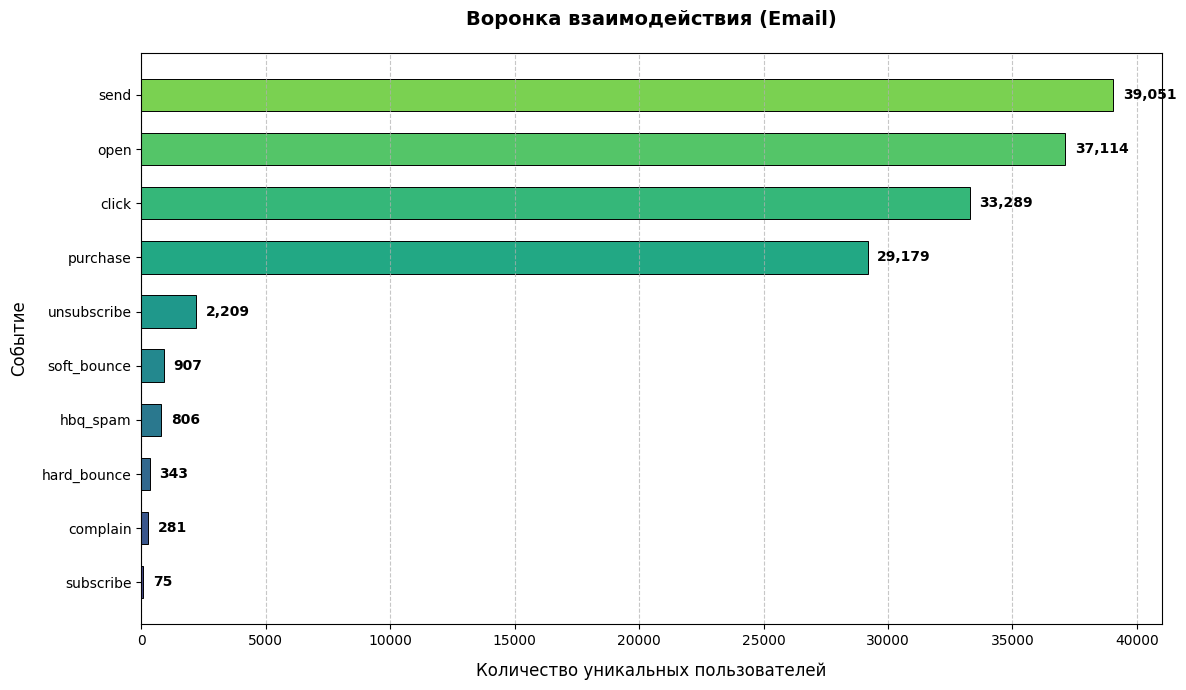

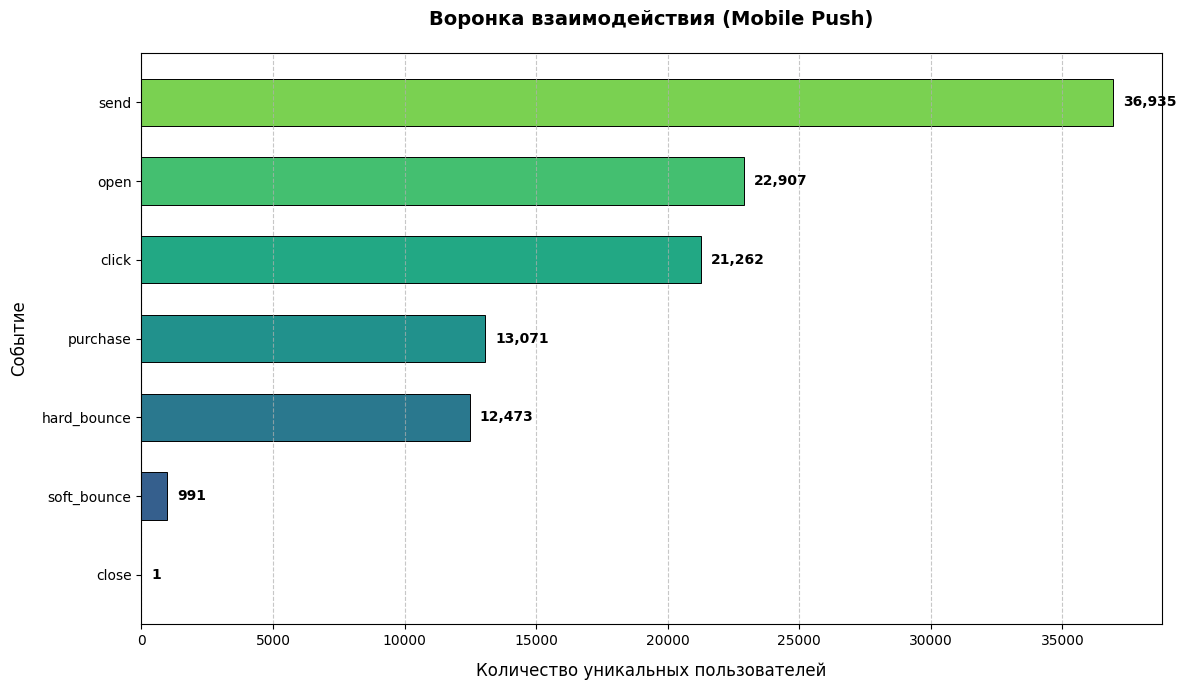

In [9]:
# Фильтруем данные для email и mobile_push
df_email = df_messages[df_messages['channel'] == 'email']
df_mobile_push = df_messages[df_messages['channel'] == 'mobile_push']

# Функция для создания воронки
def create_funnel(df, channel_name):
    funnel = df.groupby('event')['client_id'].nunique().reset_index()
    funnel = funnel.rename(columns={'client_id': 'unique_clients'})
    funnel = funnel.sort_values('unique_clients', ascending=True)
    
    plt.figure(figsize=(12, 7))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(funnel)))
    
    bars = plt.barh(
        funnel['event'], 
        funnel['unique_clients'], 
        color=colors, 
        edgecolor='black', 
        linewidth=0.7,
        height=0.6
    )
    
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + max(funnel['unique_clients']) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}',
            va='center', 
            ha='left', 
            fontsize=10,
            fontweight='bold'
        )
    
    plt.xlabel('Количество уникальных пользователей', fontsize=12, labelpad=10)
    plt.ylabel('Событие', fontsize=12, labelpad=10)
    plt.title(f'Воронка взаимодействия ({channel_name})', fontsize=14, pad=20, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Создаем воронки для каждого канала
create_funnel(df_email, 'Email')
create_funnel(df_mobile_push, 'Mobile Push')

**Анализ воронки взаимодействия пользователей с брендом показывает следующее:**

***Mobile Push:***

- Воронка начинается с этапа "send" (отправка), за которым следуют "open" (открытие), "click" (клик), и "purchase" (покупка).

- Наблюдаются потери на каждом этапе, что типично для маркетинговых воронок.

- Также присутствуют негативные метрики: "hard_bounce" (жесткий отказ), "soft_bounce" (мягкий отказ), и "dose" (возможно, ошибка в данных или опечатка).

***Email:***

- Воронка включает больше этапов: "send", "open", "click", "purchase", а также дополнительные метрики, такие как "unsubscribe" (отписка), "soft_bounce", "hbq_spam" (возможно, спам-жалобы), "hard_bounce", "complain" (жалоба), и "subscribe" (подписка).

- Числовые данные показывают значительное снижение пользователей от этапа "send" (39,051) до "purchase" (29,179), что указывает на потери в конверсии.

- Наличие таких метрик, как "unsubscribe" и "complain", свидетельствует о проблемах с вовлеченностью или релевантностью контента.

**Теперь отфильтруем тех пользователей, которыеточно не совершат покупки в ближайшие 90 дней**

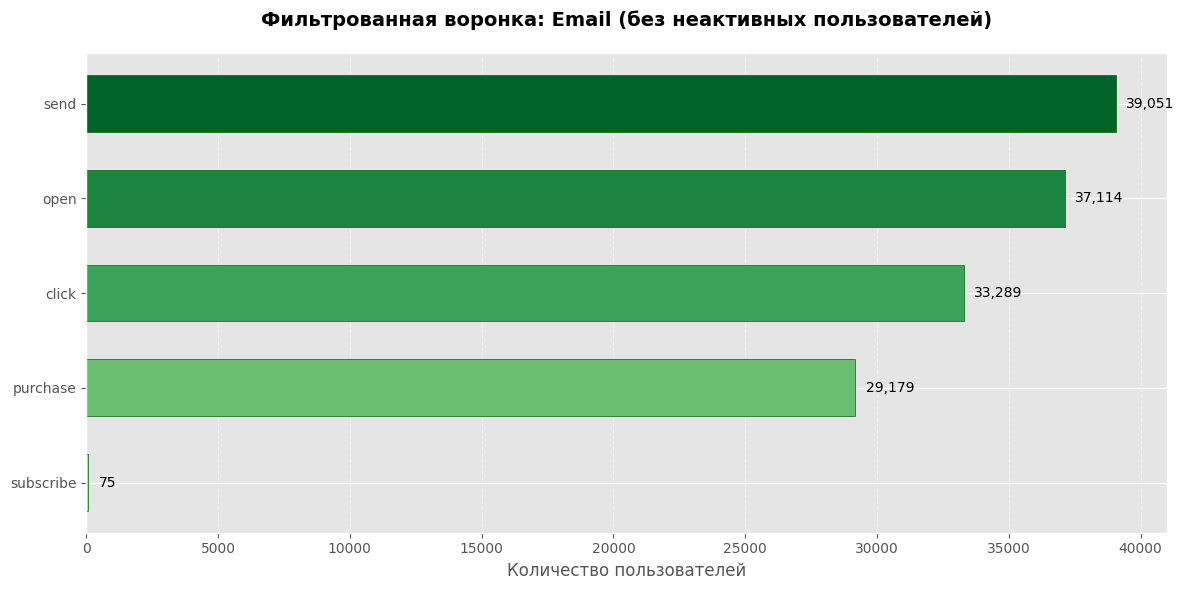

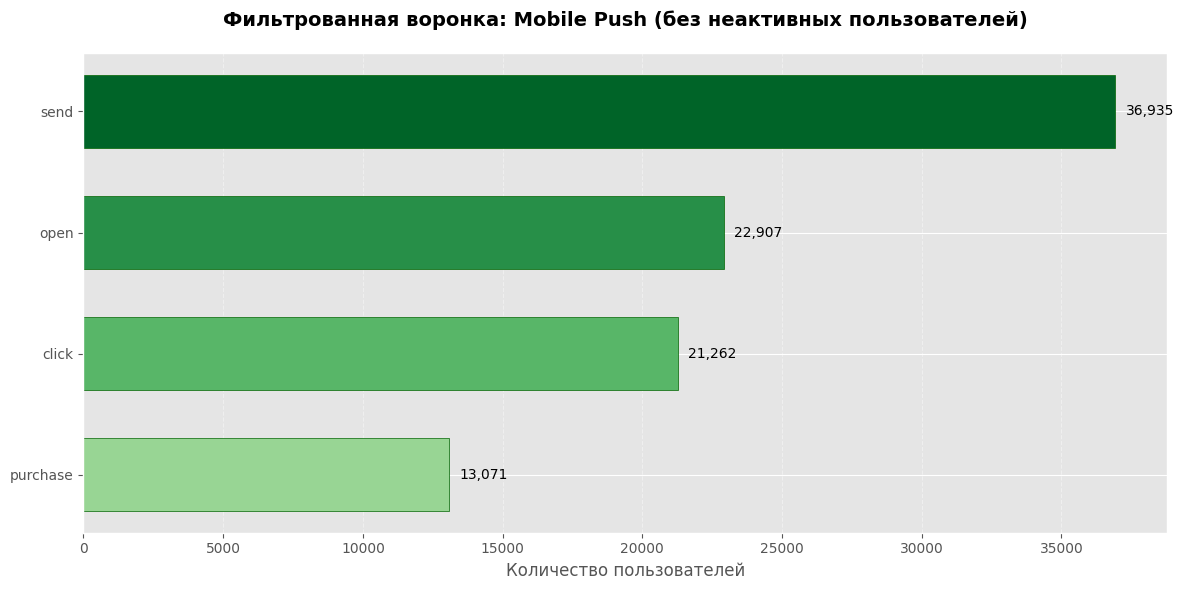

In [44]:
# Список событий для исключения
filtered_events = ['unsubscribe', 'soft_bounce', 'hbq_spam', 'hard_bounce', 'complain', 'close']

# Фильтрация для email
df_email_filtered = df_messages[
    (df_messages['channel'] == 'email') & 
    (~df_messages['event'].isin(filtered_events))
]

# Фильтрация для mobile_push
df_mobile_filtered = df_messages[
    (df_messages['channel'] == 'mobile_push') & 
    (~df_messages['event'].isin(filtered_events))
]

def plot_filtered_funnel(df, channel_name):
    # Создание воронки
    funnel = df.groupby('event')['client_id'].nunique().reset_index()
    funnel = funnel.rename(columns={'client_id': 'unique_clients'})
    funnel = funnel.sort_values('unique_clients', ascending=True)

    # Настройка стиля
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 6))

    # Цветовая схема (зеленый для позитивных событий)
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(funnel)))

    # Построение графика
    bars = plt.barh(
        funnel['event'], 
        funnel['unique_clients'], 
        color=colors, 
        edgecolor='darkgreen', 
        height=0.6
    )

    # Аннотации
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + max(funnel['unique_clients']) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}',
            va='center', 
            ha='left', 
            fontsize=10
        )

    # Оформление
    plt.title(
        f'Фильтрованная воронка: {channel_name} (без неактивных пользователей)',
        fontsize=14, 
        pad=20, 
        fontweight='bold'
    )
    plt.xlabel('Количество пользователей', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_filtered_funnel(df_email_filtered, 'Email')
plot_filtered_funnel(df_mobile_filtered, 'Mobile Push')

**Краткий вывод по графикам после фильтрации (без неактивных пользователей):**

1. Email-воронка
- Основные этапы: send → open → click → purchase → subscribe.

- Конверсия:

   - Отправлено:       39,051 пользователей.
   - Дошли до покупки: 29,179 пользователей.
   - Общая конверсия:  74.7% (Send→Purchase).

2. Mobile Push-воронка
- Основные этапы: send → open → click → purchase.

- Конверсия:

   - Отправлено:       36,935 пользователей.
   - Дошли до покупки: 13,071 пользователей.
   - Общая конверсия:  35.4% (Send→Purchase)

3. Общий итог после фильтрации:
- Email показывает стабильно высокую конверсию (75%), что делает его надежным каналом.
- Mobile Push теряет больше половины пользователей перед покупкой — нуждается в доработке.

  - Фильтрация неактивных пользователей очистила данные от "шума" (жалоб, отказов), что позволило точнее оценить здоровые этапы воронки

In [11]:
# Функция для расчета метрик воронки
def calculate_funnel_metrics(df):
    # Получаем значения для каждого этапа
    metrics = {
        'send': df[df['event'] == 'send']['client_id'].nunique(),
        'open': df[df['event'] == 'open']['client_id'].nunique(),
        'click': df[df['event'] == 'click']['client_id'].nunique(),
        'purchase': df[df['event'] == 'purchase']['client_id'].nunique()
    }
    
    # Рассчитываем конверсии
    if metrics['send'] > 0:
        metrics['open_rate'] = metrics['open'] / metrics['send'] * 100
        metrics['click_rate'] = metrics['click'] / metrics['open'] * 100 if metrics['open'] > 0 else 0
        metrics['purchase_rate'] = metrics['purchase'] / metrics['click'] * 100 if metrics['click'] > 0 else 0
        metrics['total_conversion'] = metrics['purchase'] / metrics['send'] * 100
    else:
        metrics.update({'open_rate': 0, 'click_rate': 0, 'purchase_rate': 0, 'total_conversion': 0})
    
    return metrics

# Рассчитываем метрики для каждого канала
email_metrics = calculate_funnel_metrics(df_email_filtered)
push_metrics = calculate_funnel_metrics(df_mobile_filtered)

# Создаем таблицу сравнения
comparison_data = [
    {
        'Параметр': 'Общий охват (Send)',
        'Email': f"{email_metrics['send']:,}",
        'Mobile Push': f"{push_metrics['send']:,}",
        'Разница': f"{email_metrics['send'] - push_metrics['send']:+,}"
    },
    {
        'Параметр': 'Open Rate',
        'Email': f"{email_metrics['open']:,} ({email_metrics['open_rate']:.1f}%)",
        'Mobile Push': f"{push_metrics['open']:,} ({push_metrics['open_rate']:.1f}%)",
        'Разница': f"{email_metrics['open_rate'] - push_metrics['open_rate']:+.1f}%"
    },
    {
        'Параметр': 'Click Rate',
        'Email': f"{email_metrics['click']:,} ({email_metrics['click_rate']:.1f}% от Open)",
        'Mobile Push': f"{push_metrics['click']:,} ({push_metrics['click_rate']:.1f}% от Open)",
        'Разница': f"{email_metrics['click_rate'] - push_metrics['click_rate']:+.1f}%"
    },
    {
        'Параметр': 'Purchase Rate',
        'Email': f"{email_metrics['purchase']:,} ({email_metrics['purchase_rate']:.1f}% от Click)",
        'Mobile Push': f"{push_metrics['purchase']:,} ({push_metrics['purchase_rate']:.1f}% от Click)",
        'Разница': f"{email_metrics['purchase_rate'] - push_metrics['purchase_rate']:+.1f}%"
    },
    {
        'Параметр': 'Общая конверсия',
        'Email': f"{email_metrics['total_conversion']:.1f}% (Send→Purchase)",
        'Mobile Push': f"{push_metrics['total_conversion']:.1f}% (Send→Purchase)",
        'Разница': f"{email_metrics['total_conversion'] - push_metrics['total_conversion']:+.1f}%"
    }
]

# Создаем DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Функция для стилизации таблицы
def style_comparison_table(df):
    styles = [
        {'selector': 'th', 'props': [('text-align', 'center'), 
                                   ('background-color', '#f7f7f7'),
                                   ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'left')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffffcc')]},
    ]
    
    # Добавляем цветовое оформление для колонки "Разница"
    def color_diff(val):
        if isinstance(val, str) and val.startswith('+'):
            return 'color: green'
        elif isinstance(val, str) and val.startswith('-'):
            return 'color: red'
        return ''
    
    return df.style \
        .set_table_styles(styles) \
        .applymap(color_diff, subset=['Разница']) \
        .format({'Разница': lambda x: x}) \
        .hide(axis='index')

# Отображаем стилизованную таблицу
display(style_comparison_table(df_comparison))

C:\Users\Professional\AppData\Local\Temp\ipykernel_116\1035165166.py:83: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_diff, subset=['Разница']) \


Параметр,Email,Mobile Push,Разница
Общий охват (Send),"39,051","36,935","+2,116"
Open Rate,"37,114 (95.0%)","22,907 (62.0%)",+33.0%
Click Rate,"33,289 (89.7% от Open)","21,262 (92.8% от Open)",-3.1%
Purchase Rate,"29,179 (87.7% от Click)","13,071 (61.5% от Click)",+26.2%
Общая конверсия,74.7% (Send→Purchase),35.4% (Send→Purchase),+39.3%


In [12]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [13]:
df_purchases['client_message_id'] = df_purchases['message_id'].str.split('-').str[0]
df_purchases['bulk_campaign_id_message_id'] = df_purchases['message_id'].str.split('-').str[1]
df_purchases['message_id_code'] = df_purchases['message_id'].str.split('-').str[2]

In [14]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,client_message_id,bulk_campaign_id_message_id,message_id_code
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843


In [15]:
df_purchases_copy = df_purchases.copy()
df_purchases_copy['client_message_id'] = df_purchases_copy['client_message_id'].astype('int64')
df_purchases_copy = df_purchases_copy.loc[(df_purchases_copy['client_id']==df_purchases_copy['client_message_id'])]

df_purchases_copy.shape

(146525, 9)

In [16]:
df_purchases_copy = df_purchases_copy.drop(['client_message_id', 'bulk_campaign_id_message_id', 'message_id_code'], axis=1)
print(df_purchases_copy.head())
df_purchases_copy.shape

             client_id  quantity   price               category_ids  \
0  1515915625468169594         1  1999.0   ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0   ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0   ['4', '28', '57', '431']   
3  1515915625471138230         1  4999.0  ['4', '28', '244', '432']   
4  1515915625471138230         1  4999.0   ['4', '28', '49', '413']   

        date                              message_id  
0 2022-05-16  1515915625468169594-4301-627b661e9736d  
1 2022-05-16  1515915625468169594-4301-627b661e9736d  
2 2022-05-16  1515915625471138230-4437-6282242f27843  
3 2022-05-16  1515915625471138230-4437-6282242f27843  
4 2022-05-16  1515915625471138230-4437-6282242f27843  


(146525, 6)

In [17]:
df_grouped = df_purchases_copy.groupby(['client_id', 'category_ids', 'date', 'message_id'], as_index=False).agg({'quantity': 'sum', 'price': 'sum'})
print(df_grouped.head())
df_grouped.shape

             client_id                 category_ids       date  \
0  1515915625468060902    ['4', '27', '176', '458'] 2022-05-27   
1  1515915625468060902  ['4', '27', '1828', '1599'] 2022-05-27   
2  1515915625468060902    ['4', '28', '244', '432'] 2022-05-27   
3  1515915625468060902    ['4', '28', '260', '420'] 2022-05-27   
4  1515915625468060902    ['4', '28', '290', '422'] 2022-05-27   

                               message_id  quantity   price  
0  1515915625468060902-4617-6290657dac196         2   398.0  
1  1515915625468060902-4617-6290657dac196         1  1299.0  
2  1515915625468060902-4617-6290657dac196         1   999.0  
3  1515915625468060902-4617-6290657dac196         2  3998.0  
4  1515915625468060902-4617-6290657dac196         1   299.0  


(73114, 6)

In [18]:
def extract_two_levels(cat_str):
    try:
        if isinstance(cat_str, str):
            categories = ast.literal_eval(cat_str)
            return str([str(categories[0]), str(categories[1])])  # Возвращаем строку
        return np.nan
    except:
        return np.nan

df_grouped['category_2level'] = df_grouped['category_ids'].apply(extract_two_levels)

df_grouped.head()

,client_id,category_ids,date,message_id,quantity,price,category_2level
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,2,398.0,"['4', '27']"
1,1515915625468060902,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.0,"['4', '27']"
2,1515915625468060902,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1,999.0,"['4', '28']"
3,1515915625468060902,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.0,"['4', '28']"
4,1515915625468060902,"['4', '28', '290', '422']",2022-05-27,1515915625468060902-4617-6290657dac196,1,299.0,"['4', '28']"


In [19]:
value_counts = df_grouped['category_2level'].value_counts(dropna=False)
print("Количество каждой уникальной комбинации (с NaN):")
print(value_counts)

Количество каждой уникальной комбинации (с NaN):
category_2level
['4', '28']         31135
['2', '18']          9519
['5562', '5630']     3937
['4', '27']          3705
['5562', '5631']     3312
['4', '31']          3159
['5562', '5589']     2197
NaN                  2142
['5562', '5633']     1975
['4', '29']          1607
['5562', '5536']     1546
['5562', '5634']     1487
['6060', '6058']     1433
['4', '1822']        1158
['2', '17']          1038
['5562', '5632']      648
['5562', '5597']      583
['5963', '5959']      464
['5562', '5683']      442
['4', '44']           381
['4', '5837']         357
['6060', '6057']      338
['6060', '6059']      185
['5562', '5558']      166
['5562', '5599']      133
['5562', '5697']       31
['4', '30']            27
['3', '12']             3
['1', '22']             2
['3', '14']             2
['5', '10']             1
['1', '8']              1
Name: count, dtype: int64


In [20]:
# Удаляем исходный столбец category_ids
df_grouped = df_grouped.drop(columns=['category_ids'])

# Переименовываем category_2level в category_ids
df_grouped = df_grouped.rename(columns={'category_2level': 'category_ids'})

# Удаляем строки с NaN в новом столбце category_ids
df_grouped = df_grouped.dropna(subset=['category_ids'])

# Проверяем результат
print(df_grouped.head())
print(f"\nОбщее количество строк после обработки: {len(df_grouped)}")

             client_id       date                              message_id  \
0  1515915625468060902 2022-05-27  1515915625468060902-4617-6290657dac196   
1  1515915625468060902 2022-05-27  1515915625468060902-4617-6290657dac196   
2  1515915625468060902 2022-05-27  1515915625468060902-4617-6290657dac196   
3  1515915625468060902 2022-05-27  1515915625468060902-4617-6290657dac196   
4  1515915625468060902 2022-05-27  1515915625468060902-4617-6290657dac196   

   quantity   price category_ids  
0         2   398.0  ['4', '27']  
1         1  1299.0  ['4', '27']  
2         1   999.0  ['4', '28']  
3         2  3998.0  ['4', '28']  
4         1   299.0  ['4', '28']  

Общее количество строк после обработки: 70972


In [21]:
df_grouped['day_of_week'] = df_grouped['date'].dt.dayofweek

df_grouped['year'] = df_grouped['date'].dt.year

df_grouped['avg_price'] = df_grouped['price'] / df_grouped['quantity']

df_grouped.head()

,client_id,date,message_id,quantity,price,category_ids,day_of_week,year,avg_price
0,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.0,"['4', '27']",4,2022,199.0
1,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.0,"['4', '27']",4,2022,1299.0
2,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,1,999.0,"['4', '28']",4,2022,999.0
3,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.0,"['4', '28']",4,2022,1999.0
4,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,1,299.0,"['4', '28']",4,2022,299.0


C:\Users\Professional\AppData\Local\Temp\ipykernel_116\4262551379.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='price', y='category_ids',


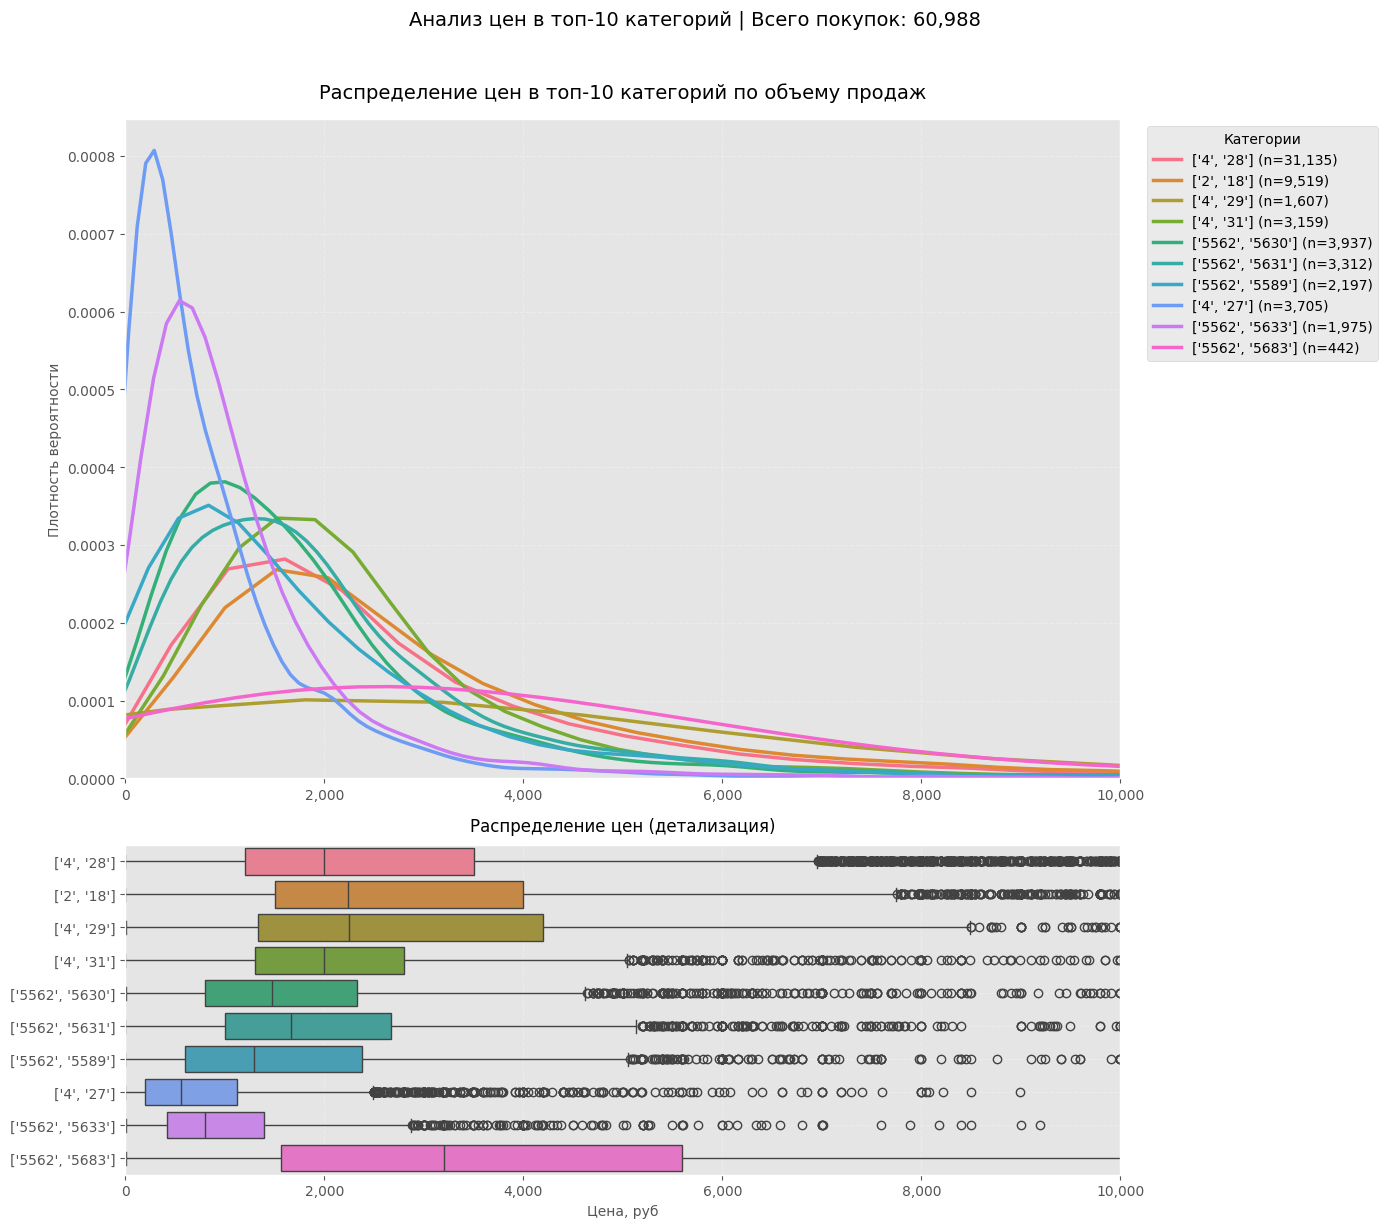

In [22]:
# Подготовка данных
top_categories = df_grouped.groupby('category_ids')['price'].sum().nlargest(10).index
filtered_data = df_grouped[df_grouped['category_ids'].isin(top_categories)]

# Создаем фигуру с 2 подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), 
                              gridspec_kw={'height_ratios': [2, 1]})

# Верхний график: распределение цен
palette = sns.color_palette("husl", len(top_categories))
for i, category in enumerate(top_categories):
    cat_data = filtered_data[filtered_data['category_ids'] == category]
    sns.kdeplot(data=cat_data, x='price', ax=ax1,
                label=f"{category} (n={len(cat_data):,})",
                color=palette[i],
                linewidth=2.5,
                common_norm=False)

ax1.set_title('Распределение цен в топ-10 категорий по объему продаж', fontsize=14, pad=15)
ax1.set_xlabel('')
ax1.set_ylabel('Плотность вероятности', fontsize=10)
ax1.set_xlim(0, 10000)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(title='Категории', bbox_to_anchor=(1.02, 1), loc='upper left')

# 2. Нижний график: boxplot
sns.boxplot(data=filtered_data, x='price', y='category_ids', 
           order=top_categories, palette=palette, ax=ax2, whis=1.5)
ax2.set_title('Распределение цен (детализация)', fontsize=12, pad=10)
ax2.set_xlabel('Цена, руб', fontsize=10)
ax2.set_ylabel('')
ax2.set_xlim(0, 10000)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.grid(True, linestyle='--', alpha=0.3)

# Общая информация
plt.suptitle(f'Анализ цен в топ-10 категорий | Всего покупок: {len(filtered_data):,}', 
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

1. Лидеры по объему продаж:

- Категория [4, 28] доминирует с 31,135 покупками (51% от топ-10)

- Следующие по популярности [2, 18] (9,519) и [4, 29] (1,607)

- Категория [5562, 5683] имеет наименьшее количество покупок (442)
- 

2. Распределение цен (KDE график):

- Все категории имеют правостороннее распределение (больше дешевых товаров)

- Пики плотности для большинства категорий находятся в диапазоне 500-2,000 руб
- 
3. Детализация по Boxplot:

- *Медианные цены (линии внутри боксов):*

  - Самая низкая: [4, 27] (~800 руб)

  - Самая высокая: [5562, 5683] (~3,500 руб)

4. Выбросы:

- Все категории имеют товары премиум-сегмента (>6,000 руб)

In [45]:
df = df_grouped.merge(df_messages, on=['client_id', 'message_id'], how='inner')
df.head()

,client_id,date_x,message_id,quantity,price,category_ids,day_of_week,year,avg_price,bulk_campaign_id,event,channel,date_y,created_at
0,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.000,"['4', '27']",4,2022,199.000,4617,send,email,2022-05-27,2022-05-27 05:49:50
1,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.000,"['4', '27']",4,2022,199.000,4617,open,email,2022-05-27,2022-05-27 10:57:52
2,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.000,"['4', '27']",4,2022,199.000,4617,click,email,2022-05-27,2022-05-27 10:59:04
3,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.000,"['4', '27']",4,2022,199.000,4617,click,email,2022-05-27,2022-05-27 11:22:53
4,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.000,"['4', '27']",4,2022,199.000,4617,purchase,email,2022-05-27,2022-05-27 11:26:49


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371219 entries, 0 to 371218
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         371219 non-null  int64         
 1   date_x            371219 non-null  datetime64[ns]
 2   message_id        371219 non-null  object        
 3   quantity          371219 non-null  int64         
 4   price             371219 non-null  float64       
 5   category_ids      371219 non-null  object        
 6   day_of_week       371219 non-null  int32         
 7   year              371219 non-null  int32         
 8   avg_price         371219 non-null  float64       
 9   bulk_campaign_id  371219 non-null  int64         
 10  event             371219 non-null  object        
 11  channel           371219 non-null  object        
 12  date_y            371219 non-null  datetime64[ns]
 13  created_at        371219 non-null  object        
dtypes: d

In [25]:
df.duplicated().sum()

8802

In [26]:
# Анализ перед удалением
dup_stats = df.groupby(df.columns.tolist()).size().reset_index(name='counts')
print("Распределение дубликатов:")
print(dup_stats['counts'].value_counts())

Распределение дубликатов:
counts
1    354461
2      7202
3       674
4        68
5        12
Name: count, dtype: int64


In [27]:
df=df.drop_duplicates()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362417 entries, 0 to 371218
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         362417 non-null  int64         
 1   date_x            362417 non-null  datetime64[ns]
 2   message_id        362417 non-null  object        
 3   quantity          362417 non-null  int64         
 4   price             362417 non-null  float64       
 5   category_ids      362417 non-null  object        
 6   day_of_week       362417 non-null  int32         
 7   year              362417 non-null  int32         
 8   avg_price         362417 non-null  float64       
 9   bulk_campaign_id  362417 non-null  int64         
 10  event             362417 non-null  object        
 11  channel           362417 non-null  object        
 12  date_y            362417 non-null  datetime64[ns]
 13  created_at        362417 non-null  object        
dtypes: dateti

In [29]:
df = df.merge(df_target, on='client_id', how='left')

In [30]:
# Активность пользователя
user_activity = df_messages.groupby('client_id')['event'].count().reset_index()
user_activity.columns = ['client_id', 'total_events']

# Доля кликов среди открытий
df_click_open = df_messages[df_messages['event'].isin(['open', 'click'])].pivot_table(
    index='client_id', columns='event', values='message_id', aggfunc='count', fill_value=0
).reset_index()
df_click_open['click_to_open_ratio'] = df_click_open['click'] / (df_click_open['open'] + 1e-6)  # Добавляем 1e-6 чтобы избежать деления на 0

# Время с последнего взаимодействия
df_messages['date'] = pd.to_datetime(df_messages['date'])
last_activity = df_messages.groupby('client_id')['date'].max().reset_index()
last_activity['days_since_last_activity'] = (pd.to_datetime('today') - last_activity['date']).dt.days

# Объединяем признаки с основным датафреймом
df = df.merge(user_activity, on='client_id', how='left')
df = df.merge(df_click_open[['client_id', 'click_to_open_ratio']], on='client_id', how='left')
df = df.merge(last_activity[['client_id', 'days_since_last_activity']], on='client_id', how='left')

In [31]:
cols = ['date_x', 'message_id', 'bulk_campaign_id', 'event', 'channel', 'date_y', 'created_at']
df = df.drop(cols, axis=1)

In [32]:
df.head()

,client_id,quantity,price,category_ids,day_of_week,year,avg_price,target,total_events,click_to_open_ratio,days_since_last_activity
0,1515915625468060902,2,398.0,"['4', '27']",4,2022,199.0,0,177,0.285714,436
1,1515915625468060902,2,398.0,"['4', '27']",4,2022,199.0,0,177,0.285714,436
2,1515915625468060902,2,398.0,"['4', '27']",4,2022,199.0,0,177,0.285714,436
3,1515915625468060902,2,398.0,"['4', '27']",4,2022,199.0,0,177,0.285714,436
4,1515915625468060902,2,398.0,"['4', '27']",4,2022,199.0,0,177,0.285714,436


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362417 entries, 0 to 362416
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   client_id                 362417 non-null  int64  
 1   quantity                  362417 non-null  int64  
 2   price                     362417 non-null  float64
 3   category_ids              362417 non-null  object 
 4   day_of_week               362417 non-null  int32  
 5   year                      362417 non-null  int32  
 6   avg_price                 362417 non-null  float64
 7   target                    362417 non-null  int64  
 8   total_events              362417 non-null  int64  
 9   click_to_open_ratio       362411 non-null  float64
 10  days_since_last_activity  362417 non-null  int64  
dtypes: float64(3), int32(2), int64(5), object(1)
memory usage: 27.7+ MB


In [34]:
df.isna().sum()

client_id                   0
quantity                    0
price                       0
category_ids                0
day_of_week                 0
year                        0
avg_price                   0
target                      0
total_events                0
click_to_open_ratio         6
days_since_last_activity    0
dtype: int64

In [35]:
df = df.dropna(subset=['click_to_open_ratio'])

In [36]:
df.isna().sum()

client_id                   0
quantity                    0
price                       0
category_ids                0
day_of_week                 0
year                        0
avg_price                   0
target                      0
total_events                0
click_to_open_ratio         0
days_since_last_activity    0
dtype: int64

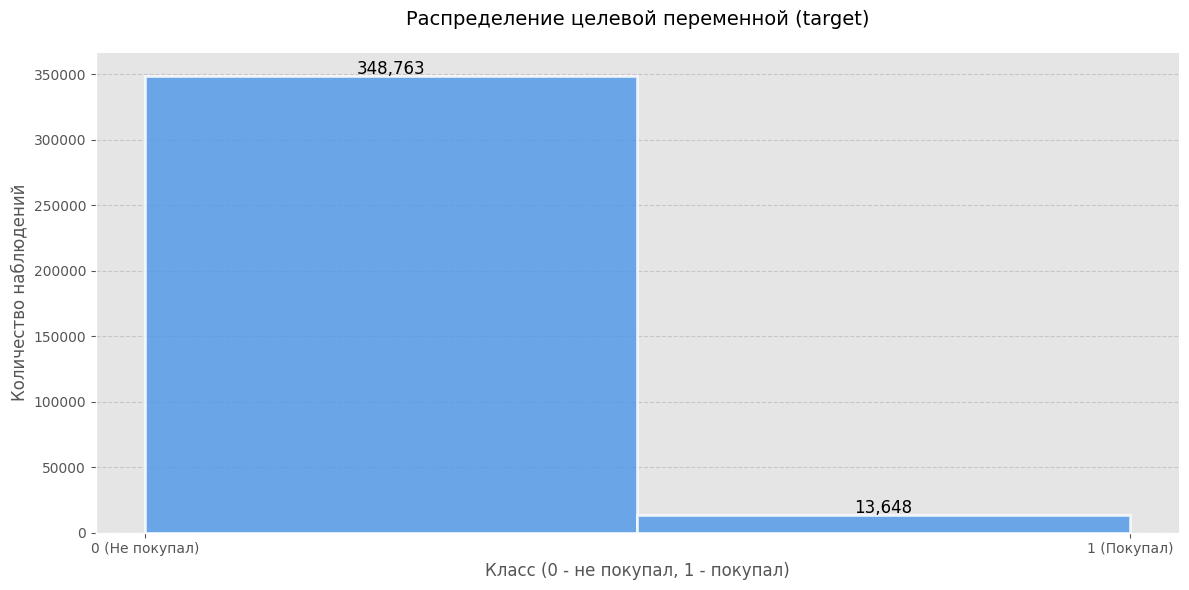

In [37]:
# Строим гистограмму с настройками
plt.figure(figsize=(12, 6))

# Строим гистограмму с настройками
ax = df['target'].hist(
    bins=2,
    color='#4B96E9',
    edgecolor='white',
    linewidth=2,
    alpha=0.8,
    grid=False
)

# Настройки оформления
plt.title('Распределение целевой переменной (target)', fontsize=14, pad=20)
plt.xlabel('Класс (0 - не покупал, 1 - покупал)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.xticks([0, 1], ['0 (Не покупал)', '1 (Покупал)'])  # Подписи для бинарных значений

# Добавляем аннотации с количеством наблюдений
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=12
    )

# Улучшаем сетку
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)

# Убираем лишние рамки
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

interval columns not set, guessing: ['quantity', 'price', 'day_of_week', 'year', 'avg_price', 'target', 'total_events', 'click_to_open_ratio', 'days_since_last_activity']


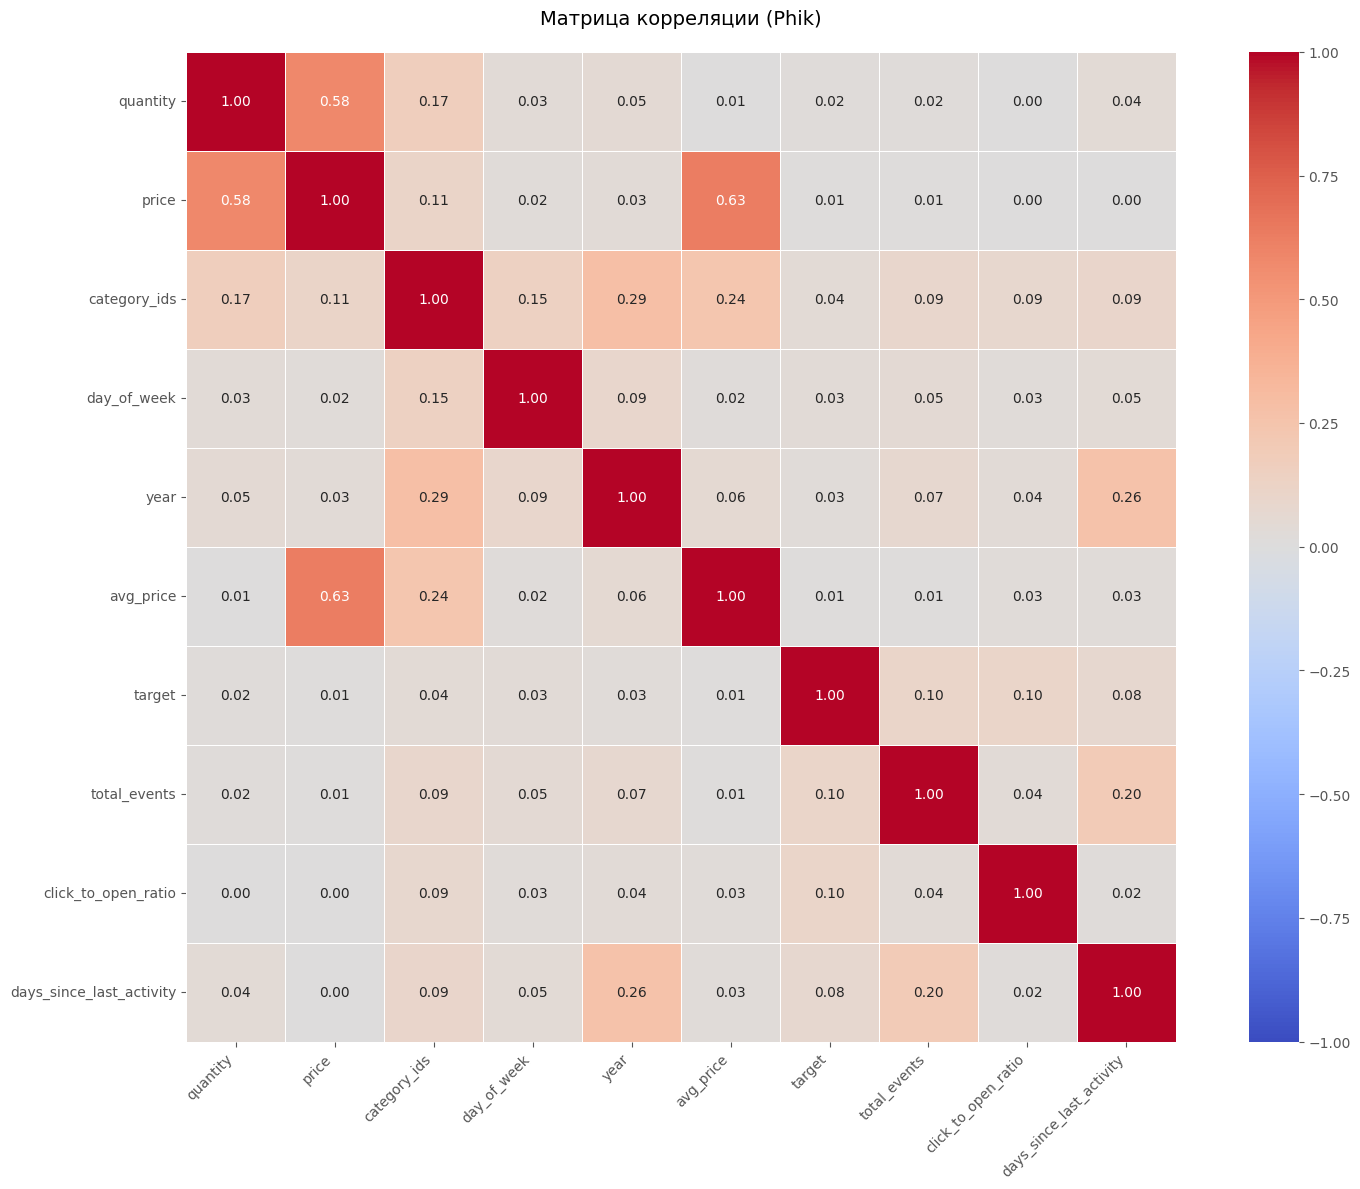

In [38]:
# Строим матрицу корреляции
plt.figure(figsize=(16, 12))

# Строим heatmap с настройками
sns.heatmap(
    df.drop(['client_id'], axis=1).phik_matrix(),
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".2f",
    annot_kws={'size': 10},
    linewidths=0.5,
    square=True
)

# Настройки оформления
plt.title('Матрица корреляции (Phik)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

#### Вывод по блоку: исследовательский анализ

***Эффективность маркетинговых каналов:***

- Email демонстрирует высокую конверсию (74.7% от отправки до покупки), что делает его наиболее надежным каналом. Пользователи активно открывают письма (95%) и совершают покупки после клика (87.7%).

- Mobile Push значительно уступает по конверсии (35.4%). Основные потери происходят на этапе перехода от клика к покупке (61.5%), что указывает на необходимость оптимизации CTA или упрощения процесса оплаты.

***Распределение целевой переменной (покупки):***

- Большинство пользователей не совершают покупки (явный дисбаланс классов: 0 — не покупали, 1 — покупали). Это важно учитывать при построении прогнозных моделей.

***Корреляционный анализ (Phik):***

- Сильная связь: quantity и price (0.58), что логично — чем больше товаров в заказе, тем выше общая стоимость.

- Слабая связь с целевой переменной (target): Наибольшая корреляция у total_events (0.10) и click_to_open_ratio (0.10), что говорит о влиянии активности пользователя на покупки.

- Незначимые факторы: День недели (day_of_week), год (year) и средняя цена (avg_price) почти не влияют на целевую переменную.

***Анализ категорий товаров:***

- Лидеры продаж: Категории [4, 28] (51% топ-10) и [2, 18] — ключевые для бизнеса.

***Ценовое распределение:***

- Большинство товаров сосредоточено в диапазоне 500–2,000 руб. (правостороннее распределение).
- 
- Премиум-сегмент (выбросы >6,000 руб.) присутствует во всех категориях, но менее популярен.

### 4. Подготовка данных и обучение моделей ###

In [41]:
# Преобразуем строки в списки
df['category_ids'] = df['category_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Создаем бинарные признаки для каждой категории
mlb = MultiLabelBinarizer()
category_features = pd.DataFrame(mlb.fit_transform(df['category_ids']), 
                               columns=[f'cat_{i}' for i in mlb.classes_],
                               index=df.index)

# Объединяем с основными признаками
features = ['total_events', 'click_to_open_ratio', 'days_since_last_activity', 'price', 'quantity']
X = pd.concat([df[features], category_features], axis=1)
y = df['target']

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Обработка дисбаланса (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Метрика для оптимизации (F2-score)
scorer = make_scorer(fbeta_score, beta=2)

# Параметры для GridSearchCV
param_grids = {
    'RandomForest': {
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [10, 20],
        'class_weight': ['balanced', {0: 1, 1: 5}]
    },
    'XGBoost': {
        'scale_pos_weight': [5, 10, 15],
        'gamma': [0.1, 0.5],
        'subsample': [0.7, 0.9]
    },
    'CatBoost': {
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3],
        'auto_class_weights': ['Balanced', 'SqrtBalanced']
    }
}

# Обучение и оценка моделей
results = {}
best_models = {}

for name, params in param_grids.items():
    print(f"\n=== Обучение {name} ===")
    
    # Выбор модели
    if name == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif name == 'XGBoost':
        model = XGBClassifier(random_state=42)
    else:
        model = CatBoostClassifier(silent=True, random_state=42)
    
    # Поиск по сетке
    grid = GridSearchCV(
        model, params, 
        scoring=scorer, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1
    )
    grid.fit(X_resampled, y_resampled)
    
    # Лучшая модель
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    # Предсказания
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Расчет метрик
    results[name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'F2-score': fbeta_score(y_test, y_pred, beta=2)
    }
    
    print(f"Лучшие параметры: {grid.best_params_}")
    print(classification_report(y_test, y_pred))

# Оптимизация порога для CatBoost (максимизация precision)
catboost_probs = best_models['CatBoost'].predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, catboost_probs)
optimal_idx = np.argmax(precisions >= 0.55)  # Порог для precision >= 55%
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (catboost_probs >= optimal_threshold).astype(int)

# Добавляем метрики оптимизированного CatBoost в результаты
results['CatBoost_Optimized'] = {
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'ROC-AUC': roc_auc_score(y_test, catboost_probs),
    'F2-score': fbeta_score(y_test, y_pred_optimal, beta=2),
    'Threshold': optimal_threshold
}

# Вывод итоговых метрик
print("\n" + "="*50)
print("ИТОГОВЫЕ МЕТРИКИ ВСЕХ МОДЕЛЕЙ".center(50))
print("="*50)

# Создаем DataFrame для вывода
metrics_df = pd.DataFrame(results).T
metrics_df['Threshold'] = '-'
metrics_df.loc['CatBoost_Optimized', 'Threshold'] = f"{optimal_threshold:.3f}"

# Переупорядочиваем столбцы
metrics_df = metrics_df[['Precision', 'Recall', 'ROC-AUC', 'F2-score', 'Threshold']]

# Форматируем вывод
pd.set_option('display.float_format', '{:.3f}'.format)
print(metrics_df)

# Детальный отчет для оптимизированного CatBoost
print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ДЛЯ OPTIMIZED CATBOOST".center(50))
print("="*50)
print(classification_report(y_test, y_pred_optimal))
print(f"Оптимальный порог классификации: {optimal_threshold:.3f}")


=== Обучение RandomForest ===
Лучшие параметры: {'class_weight': {0: 1, 1: 5}, 'max_depth': 15, 'min_samples_leaf': 10}
              precision    recall  f1-score   support

           0       1.00      0.30      0.47    104630
           1       0.05      0.99      0.10      4094

    accuracy                           0.33    108724
   macro avg       0.53      0.65      0.28    108724
weighted avg       0.96      0.33      0.45    108724


=== Обучение XGBoost ===
Лучшие параметры: {'gamma': 0.5, 'scale_pos_weight': 5, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       1.00      0.66      0.80    104630
           1       0.10      0.97      0.18      4094

    accuracy                           0.68    108724
   macro avg       0.55      0.82      0.49    108724
weighted avg       0.96      0.68      0.77    108724


=== Обучение CatBoost ===
Лучшие параметры: {'auto_class_weights': 'Balanced', 'depth': 6, 'l2_leaf_reg': 1}
              p

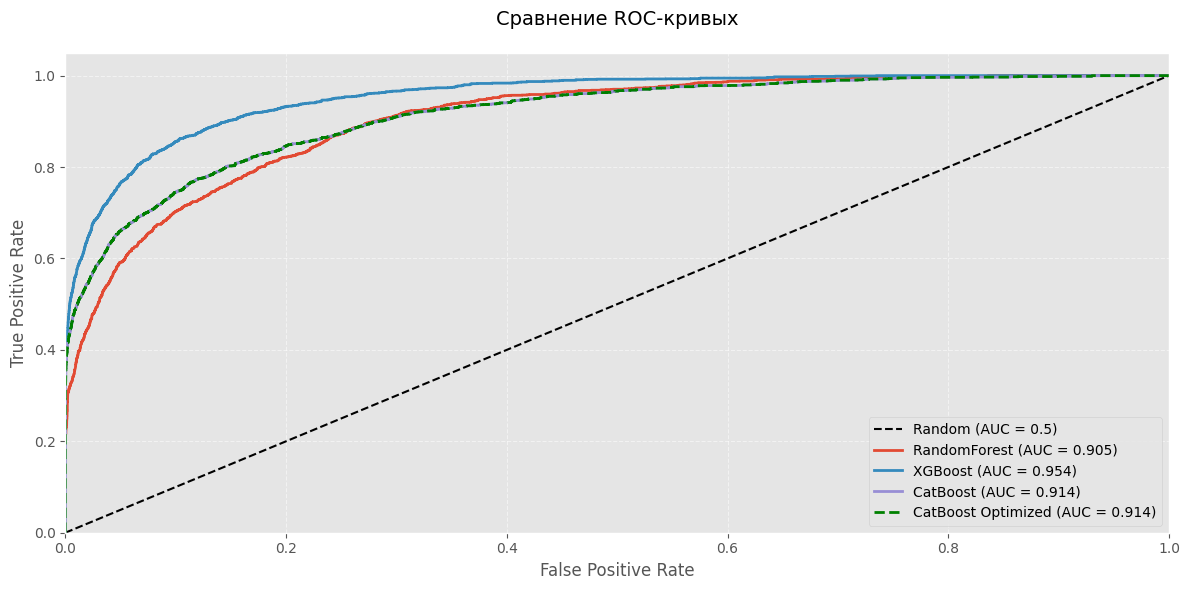

In [43]:
# Создаем фигуру для ROC-кривой
plt.figure(figsize=(12, 6))

# Отрисовка диагонали
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# ROC-кривые для всех моделей
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label=f'{name} (AUC = {roc_auc:.3f})',
             linewidth=2)

# ROC-кривая для CatBoost с оптимизированным порогом
fpr_opt, tpr_opt, _ = roc_curve(y_test, catboost_probs)
plt.plot(fpr_opt, tpr_opt, '--', 
         label=f'CatBoost Optimized (AUC = {roc_auc_score(y_test, catboost_probs):.3f})',
         linewidth=2,
         color='green')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых', fontsize=14, pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

#### Вывод по блоку: подготовка данных и обучение моделей 

***Подготовка данных:***
- Категориальные признаки:

   - Преобразованы из строкового формата (например, "[4, 28]") в бинарные признаки с помощью MultiLabelBinarizer. Это позволило учесть влияние каждой категории товаров на целевую переменную.

- Числовые признаки:

- Использованы ключевые метрики взаимодействия пользователей:

   - total_events — общая активность.

   - click_to_open_ratio — эффективность взаимодействия с письмами/Push.

   - days_since_last_activity — время с последней активности (индикатор "холодных" пользователей).

   - price и quantity — финансовые показатели заказов.

***Масштабирование:***

- Данные стандартизированы (StandardScaler) для корректной работы алгоритмов, чувствительных к масштабу (например, градиентного бустинга).

***Дисбаланс классов:***

- Применен SMOTE для увеличения числа примеров класса 1 (покупатели) в обучающей выборке.

***Обучение моделей:***
- Были выбраны три ансамблевые модели, устойчивые к переобучению и эффективные на несбалансированных данных:

   - RandomForest:

   - Гиперпараметры:

   - max_depth (глубина дерева),

   - min_samples_leaf (минимальное число объектов в листе),

   - class_weight (балансировка классов).

- Стратегия: оптимизация F2-скор (учитывает recall важнее precision).

   - XGBoost:

   - Гиперпараметры:

   - scale_pos_weight (увеличение веса класса 1),

   - gamma (регуляризация),

   - subsample (доля данных для обучения каждого дерева).

- Особенность: встроенная обработка дисбаланса через scale_pos_weight.

   - CatBoost:

   - Гиперпараметры:

   - depth (глубина деревьев),

   - l2_leaf_reg (L2-регуляризация),

   - auto_class_weights (автоматическая балансировка).

- Оптимизация: дополнительный подбор порога классификации для достижения precision ≥ 55%.

### 5. Итоговый вывод ###

***Прогнозирование покупок:***

- Модель CatBoost с порогом 0.672 рекомендована для предсказания вероятности покупки в течение 90 дней. Она обеспечивает:

   - Умеренную точность (55%), минимизируя ложные срабатывания.

   - Достаточную полноту (53%), чтобы не пропускать потенциальных покупателей.

   - ROC-AUC = 0.914 подтверждает высокую способность модели отделять покупателей от непокупателей.

- Рекомендации:

   - Для Email: Усилить триггерные письма, особенно для этапа subscribe.

   - Для Mobile Push: Упростить процесс покупки после клика (A/B-тесты CTA).

   - Для товарного ассортимента: Активно продвигать категории-лидеры ([4, 28], [2, 18]).

- Для модели:

   - Добавить временные фичи (например, частоту покупок),

   - Мониторинг метрик на новых данных.

***Заключение***
Проект успешно решил задачу прогнозирования покупок с учетом дисбаланса данных. Оптимизированная модель CatBoost позволяет маркетинговым командам фокусироваться на пользователях с высокой вероятностью конверсии, повышая ROI кампаний. Дальнейшая работа должна быть направлена на улучшение мобильного канала и уточнение признаков для модели.

In [46]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
